In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pickle as pkl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

In [15]:
def load_file(path):
  with open(path, 'rb') as f:
    return(pkl.load(f))

class PHMTestDataset_Sequential(Dataset):
    """PHM data set where each item is a sequence"""
    def __init__(self, dataset='', seq_len=5):
       
        self.data = load_file(dataset)
        self.seq_len = seq_len
    
    def __len__(self):
        return self.data['x'].shape[0]-self.seq_len+1
    
    def __getitem__(self, i):
        sample = {'x': torch.from_numpy(self.data['x'][i:i+self.seq_len])}
        return sample

**CNN + LSTM Model**

In [9]:
def conv_bn_relu(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', batch_norm=True):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode)
    nn.init.xavier_uniform_(conv.weight)
    relu = nn.ReLU()
    if batch_norm:
        return nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels),
            relu
        )
    else:
        return nn.Sequential(
            conv,
            relu
        )

class CNN_CWT_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_bn_relu(2, 16, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = conv_bn_relu(16, 32, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = conv_bn_relu(32, 64, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv4 = conv_bn_relu(64, 128, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(p=0.2)
 
    def forward(self, x):
        # input shape = [Nx2x128x128]
        x = self.conv1(x) # [Nx16x128x128]
        x = self.pool1(x) # [Nx16x64x64]
        x = self.conv2(x) # [Nx32x64x64]
        x = self.pool2(x) # [Nx32x32x32]
        x = self.conv3(x) # [Nx64x32x32]
        x = self.pool3(x) # [Nx64x16x16]
        x = self.conv4(x) # [Nx128x16x16]
        x = self.pool4(x) # [Nx128x8x8]
        x = self.flatten(x) # [Nx8192] {128*8*8=8192} (N => batch size, 128 => no. of channels, 8*8 => height of image*width of image)
        x = self.fc1(x) # [Nx256] 
        # x = self.dropout1(x) # apply dropout (Dropout is much harder to implement in LSTM)
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc2(x) # [Nx128]
        x = nn.ReLU()(x) # apply ReLU activation
        return x

class CNN_LSTM_FP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNN_CWT_Encoder()
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        # input shape = [N x l x 2 x 128 x 128] Here, N - batch size, l - sequence length (i.e. SEQ_LEN = 5),  2 - no. of channels or no. of filters, 
                                                      # 128 * 128 - height of an image * width of an image
        batch_size, seq_len, C, H, W = x.size()
        x = x.view(batch_size*seq_len, C, H, W) # transform input of shape [N x l x 2 x 128 x 128] into input of shape [(Nxl) x 2 x 128 x 128]. basically,
                                                # converting(= transforming) into sequences. [(Nxl) x 2 x 128 x 128] - transformed input sequence
        x = self.encoder(x) # pass transformed input sequence through CNN Encoder, CNN Encoder converts the image input data sequence of shape 
                            # [(Nxl) x 2 x 128 x 128] into linear vector sequence by flatenning, output feature vector sequence shape = [(Nxl) x 128]
        x = x.view(batch_size, seq_len, -1) # transform encoded feature vector sequence into time distributed(= shared, alloted, assigned) input as required by
                                            # LSTM unit or LSTM cell
        x, _ = self.lstm1(x) # pass transformed encoded feature vector sequence through LSTM unit or LSTM cell, _ variable contains the hidden layers or hidden
                             # states of LSTM, we don't require those hidden layers in our implementation, therefore just stored in _ variable, and if we want
                             # we can initialize(= activate, start) hidden states from _ variable, here hidden states are the array of zeroes
        x = self.fc(x[:,-1,:]) # pass last vector sequence(i.e. output vector sequence of LSTM unit at last time step) through fully connected network layer
        x = nn.Sigmoid()(x)
        return x    

**Switching from CPU to GPU**

In [10]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Declaring a variable "device" which will hold the device(i.e. either GPU or CPU) we are 
                                                                      #training the model on
print(device)
device


cuda:0


device(type='cuda', index=0)

**Connecting(=linking) our model to the device(GPU) to train the model on GPU**

In [11]:
model = CNN_LSTM_FP().to(device)

**Loading the Model**

In [26]:
model.load_state_dict(torch.load('/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/model/cnn_lstm_model1.pth'))

<All keys matched successfully>

**Applying Inference**

Inference - Inference refers to the process of using a trained machine learning model to make a prediction. Basically inference means validating the trained model

In [27]:
def model_inference_helper(model, dataloader):
    results = {'predictions':[]}
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)

        with torch.no_grad():
            y_prediction = model(x)

        if y_prediction.size(0)>1:
            results['predictions'] += y_prediction.cpu().squeeze().tolist()
        elif y_prediction.size(0)==1:
            results['predictions'].append(y_prediction.cpu().squeeze().tolist())
    return results

In [28]:
test_file = "/content/drive/MyDrive/FEMO2012 CHALLENGE /Dataset/test/1d_2d_merged_data/Bearing1_3.pkz"
test_dataset = PHMTestDataset_Sequential(dataset=test_file)

In [29]:
Batch_size = 16

# here dataloader() that loads batch of 16 samples(test data sequences) at a time 
dataloaders = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False, num_workers=1)  

In [30]:
results = model_inference_helper(model,dataloaders)

**Plot**

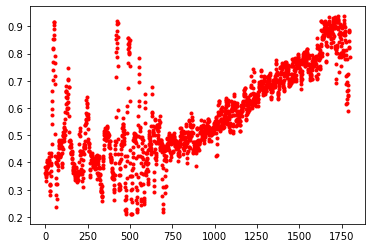

In [31]:
plt.scatter(range(len(results['predictions'])), results['predictions'], c = 'r', marker='.', label='predicted values')

In [33]:
from sklearn.linear_model import LinearRegression

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct, RBF, RationalQuadratic

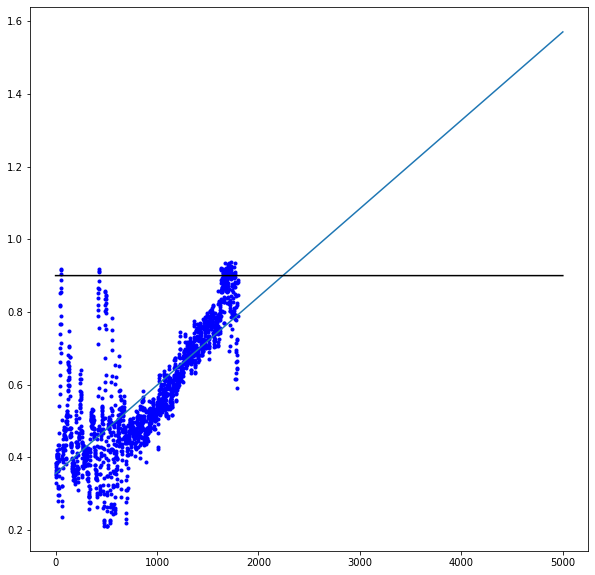

In [34]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

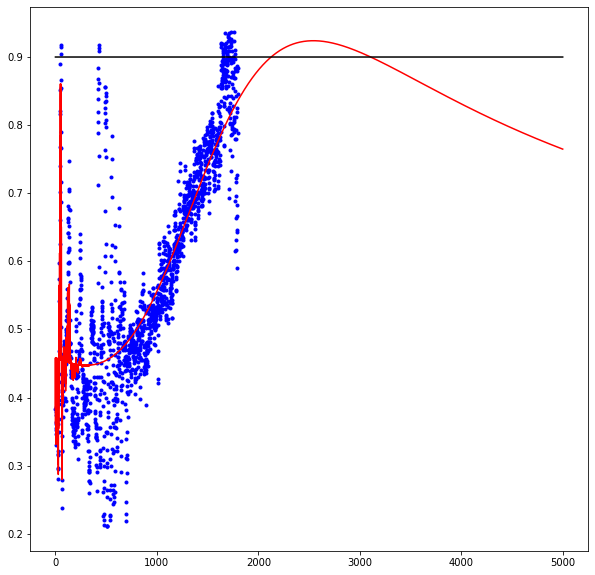

In [35]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()